In [1]:
from astropy.io import fits
import os
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
zvrk_psd = pd.read_csv(os.getcwd() + '/psd_data/zvrk/zvrk_BGCorr_PSD.txt', header=None, delim_whitespace=True)
zvrk_psd.columns=['freq', 'power']
# /home/marc/notebooks/tompok/zvrk/Analysis/Seismology --- Data Analysis/psd_data/zvrk/zvrk_multitaper_PSD.txt

In [3]:
kep_psd1 = pd.read_csv(os.getcwd() + '/psd_data/kep/KIC8816353_BGCorr_PSD.txt', header=None, delim_whitespace=True)
kep_psd2 = pd.read_csv(os.getcwd() + '/psd_data/kep/KIC4908025_BGCorr_PSD.txt', header=None, delim_whitespace=True)

kep_psd1.columns=kep_psd2.columns=['freq', 'power']

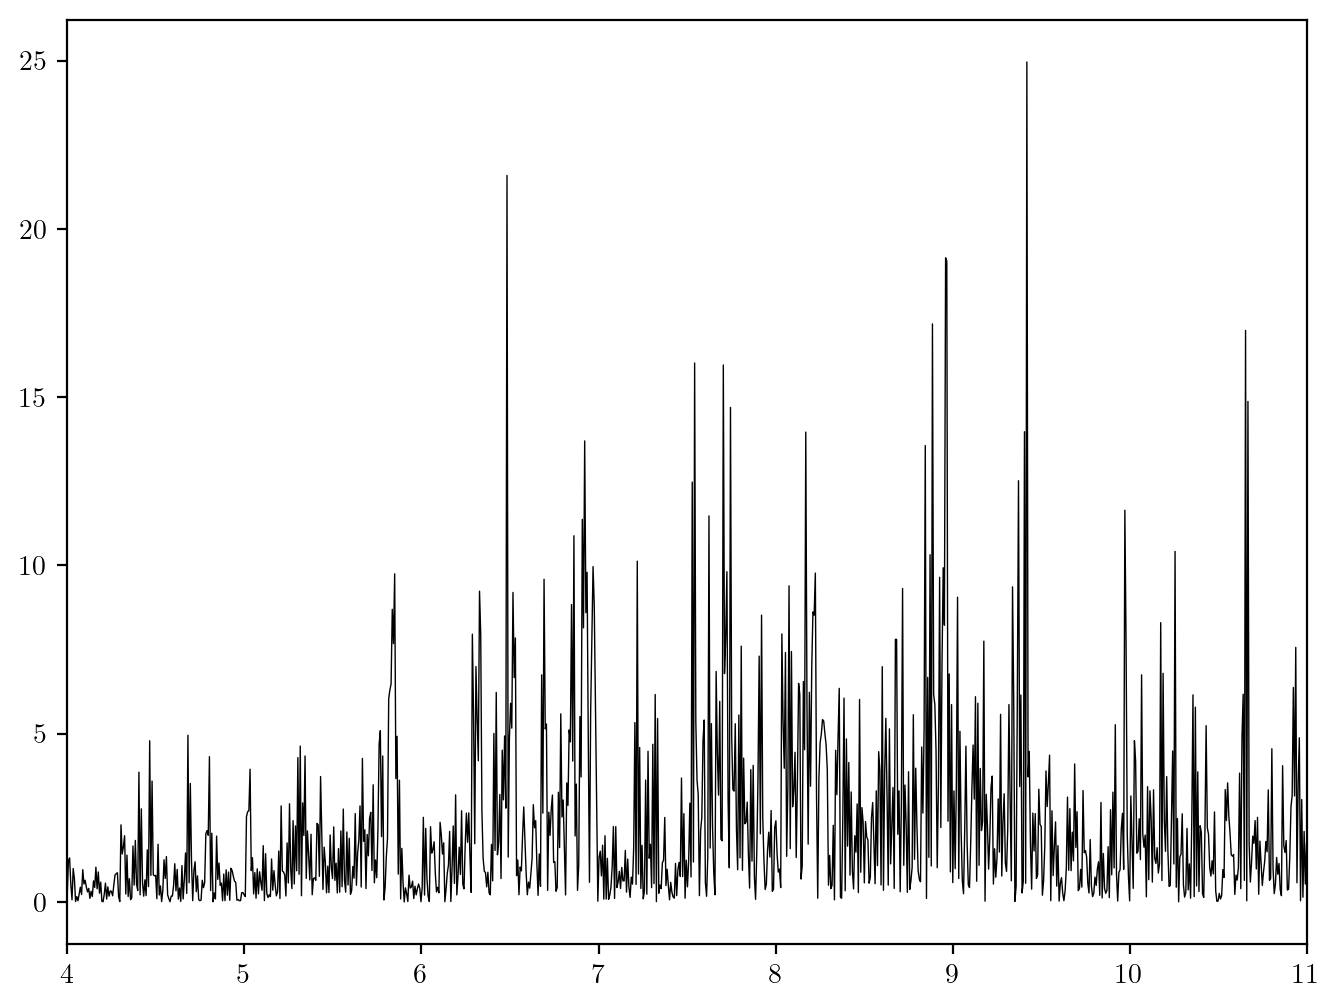

In [4]:
plt.plot(zvrk_psd.freq, zvrk_psd.power, c='k', lw=0.5)
plt.xlim(4, 11)
plt.show()

In [5]:
from scipy.ndimage import gaussian_filter1d

def echelle(freq, power, dnu, fmin=0.0, fmax=None, offset=0.0, sampling=0.1):
    if fmax is None:
        fmax = freq[-1]

    fmin = fmin - offset
    fmax = fmax - offset
    freq = freq - offset

    if fmin <= 0.0:
        fmin = 0.0
    else:
        fmin = fmin - (fmin % dnu)

    # trim data
    index = (freq >= fmin) & (freq <= fmax)
    trimx = freq[index]
    
    samplinginterval = np.median(trimx[1:-1] - trimx[0:-2]) * sampling
    xp = np.arange(fmin, fmax + dnu, samplinginterval)
    yp = np.interp(xp, freq, power)

    n_stack = int((fmax - fmin) / dnu)
    n_element = int(dnu / samplinginterval)

    morerow = 2
    arr = np.arange(1, n_stack) * dnu
    arr2 = np.array([arr, arr])
    yn = np.reshape(arr2, len(arr) * 2, order="F")
    yn = np.insert(yn, 0, 0.0)
    yn = np.append(yn, n_stack * dnu) + fmin + offset

    xn = np.arange(1, n_element + 1) / n_element * dnu
    z = np.zeros([n_stack * morerow, n_element])
    for i in range(n_stack):
        for j in range(i * morerow, (i + 1) * morerow):
            z[j, :] = yp[n_element * (i) : n_element * (i + 1)]
    return xn, yn, z

def plot_echelle(
    freq,
    power,
    dnu,
    mirror=False,
    ax=None,
    cmap="Blues_r",
    scale=None,  # "sqrt",
    interpolation=None,
    smooth=True,
    smooth_filter_width=1,
    scale_dnu = False,
    vmax=None,
    **kwargs
):
    if smooth:
        power = gaussian_filter1d(power, smooth_filter_width)
    echx, echy, echz = echelle(freq, power, dnu, **kwargs)
    if scale_dnu:
        echx /= dnu
    if scale is not None:
        if scale is "log":
            echz = np.log10(echz)
        elif scale is "sqrt":
            echz = np.sqrt(echz)
    if ax == None:
        fig, ax = plt.subplots()
    ax.imshow(
        echz,
        aspect="auto",
        extent=(echx.min(), echx.max(), echy.min(), echy.max()),
        origin="lower",
        cmap=cmap,
        interpolation=interpolation,
        vmax=vmax
    )


    ax.set_xlabel(r"Frequency" + " mod " + str(dnu))
    ax.set_ylabel(r"Frequency")
    return ax

<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_434348/865582159.py:62: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if scale is "log":
/tmp/ipykernel_434348/865582159.py:64: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif scale is "sqrt":


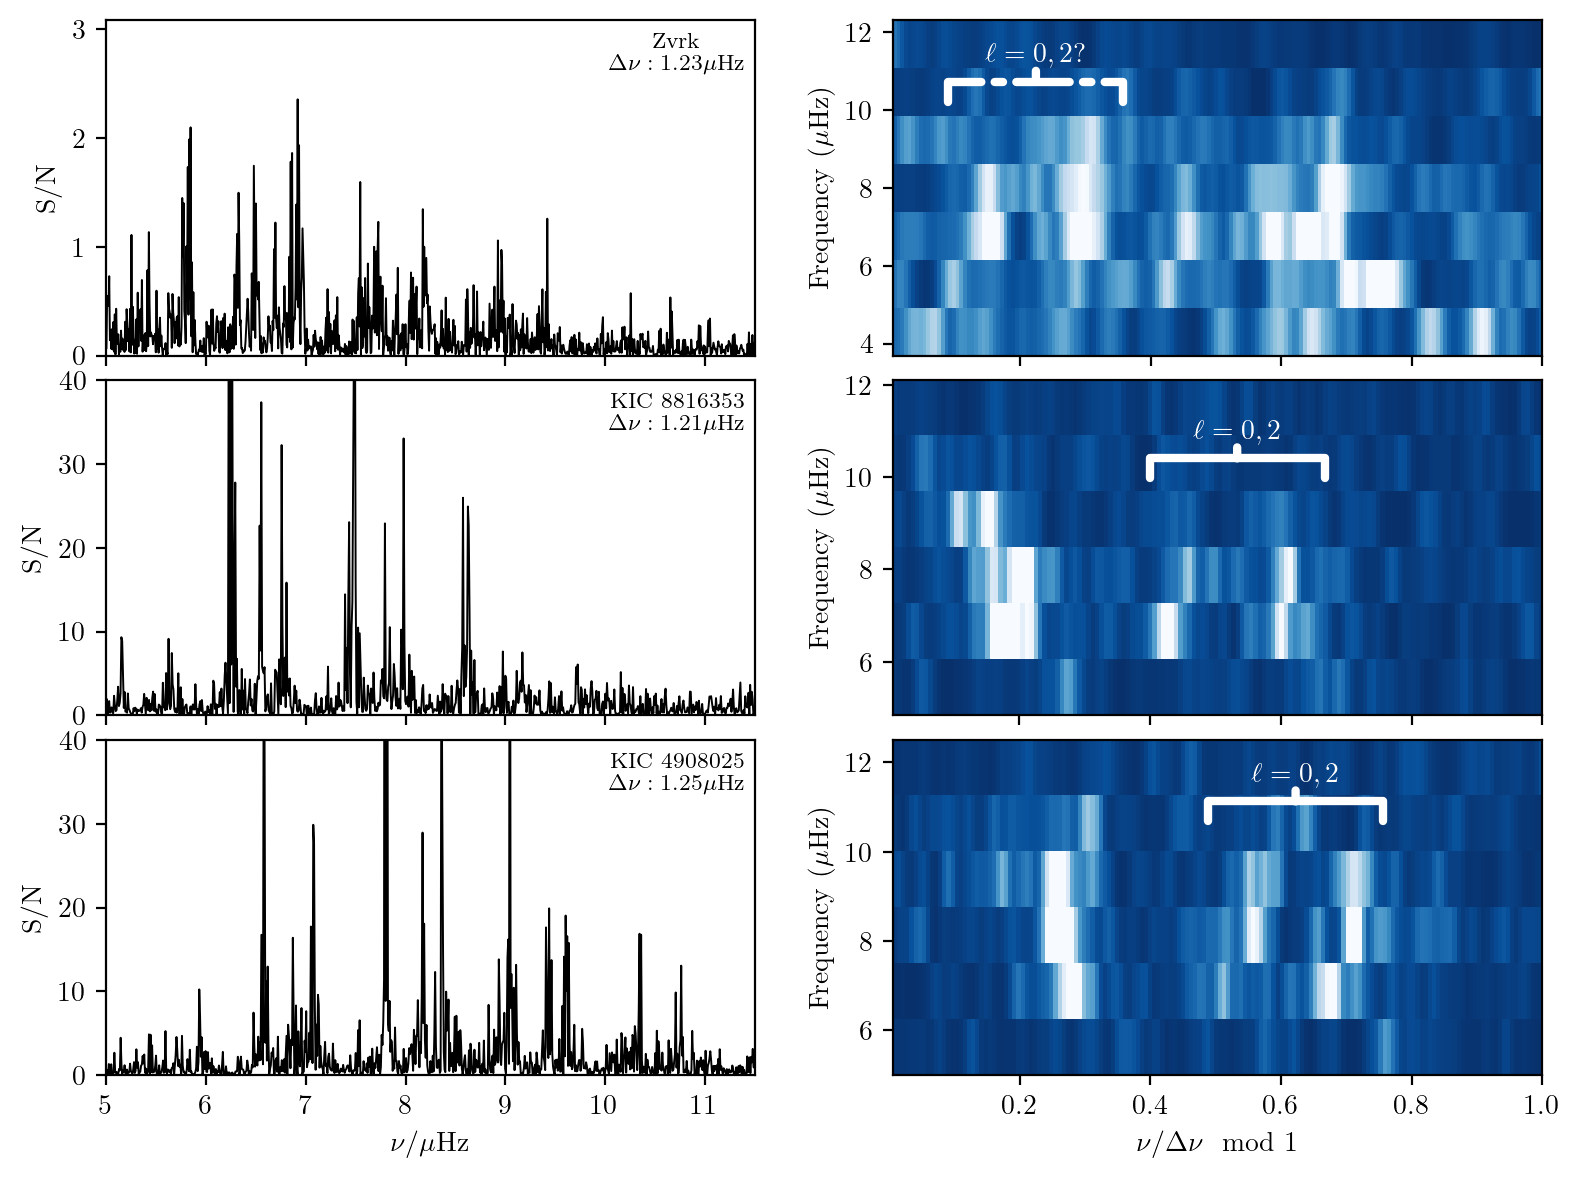

In [7]:
fig = plt.figure(figsize=(8,6))
ax1, ax2, ax3 = fig.add_subplot(321), fig.add_subplot(323), fig.add_subplot(325)
ax1a, ax2a, ax3a = fig.add_subplot(322), fig.add_subplot(324), fig.add_subplot(326)
axlist = [ax1, ax2, ax3]
imlist = [ax1a, ax2a, ax3a]
dflist = [zvrk_psd, kep_psd1, kep_psd2]
dnulist = [1.23, 1.21, 1.25]
limlist = [(4.5, 12.5), (5.5, 12.5), (5.5, 12.5)]
ylimlist = [(0,None), (0, 40), (0,40)]
bracklist = [(0.22, 0.8), (0.53, 0.75), (0.62, 0.8)]
vmaxlist = [.7, 15, 15]
labellist = ['Zvrk', 'KIC 8816353', 'KIC 4908025']
lw=0.7

ax1.set_xlim(5, 11.5)
ax2.set_xlim(ax1.get_xlim())
ax3.set_xlim(ax1.get_xlim())


for i, ax in enumerate(axlist):
    ax.plot(dflist[i].freq, dflist[i].power, c='k', lw=lw)
    im = plot_echelle(dflist[i].freq.values, 
                      dflist[i].power.values,
                      dnu=dnulist[i], fmin=limlist[i][0], fmax=limlist[i][1],
                      ax=imlist[i], scale_dnu=True, vmax=vmaxlist[i],
                      sampling=1, smooth_filter_width=1.5 if not i else 1)#,cmap='inferno'   

    im.tick_params(axis='both', which='major')
    ax.tick_params(axis='both', which='major')
    im.set_ylabel('Frequency ($\\mu$Hz)')
    ax.set_ylabel('S/N')

    ax.set_ylim(ylimlist[i])
    ax.text(transform=ax.transAxes, x=0.88, y=0.85, s=labellist[i]+'\n$\\Delta\\nu: %.2f \\mu$Hz'%dnulist[i],
            fontsize=8, ha='center')
    
    

    if i == 0:
        im.annotate(' ', xy=bracklist[i], xytext=bracklist[i], xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.75, lengthB=0.4', ls='-.', lw=3.0, color='white'))
        im.text(x=bracklist[i][0], y=bracklist[i][1]+0.075, s=r'$\ell = 0, 2?$', transform=im.transAxes,
           ha='center', color='white', fontweight='bold')
    else:
        im.annotate(' ', xy=bracklist[i], xytext=bracklist[i], xycoords='axes fraction', 
            fontsize=18, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.75, lengthB=0.4', ls='-', lw=3.0, color='white'))
        im.text(x=bracklist[i][0], y=bracklist[i][1]+0.075, s=r'${\ell = 0, 2}$', transform=im.transAxes,
           ha='center', color='white', fontweight='bold')
    

    
    if i == (len(axlist) - 1):
        im.set_xlabel(r'$\nu/\Delta\nu \mod 1$')
        ax.set_xlabel(r'$\nu/\mu$Hz')
    else:
        im.set_xlabel('')
        im.set_xticklabels([])
        ax.set_xticklabels([])

plt.tight_layout(h_pad=0)
plt.savefig('echelle_comparison.pdf', bbox_inches='tight', transparent=True)
plt.show()